In [44]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
map_img = io.imread("data/map.png")

with open("data/laser_log2303.csv", "r") as data:
    laser_db = pd.read_csv(data, delimiter=";").copy()

trail = []
for i in laser_db.values:
    if i[2] == 3.14159:
        trail.append(i[4:6])

#map_img = map_img /255

In [79]:
for i in trail:
    x = 288-int(i[0] // 0.05) #288
    y = 428-int(i[1] // 0.05) #428
    map_img[y][x] = 50

In [8]:
dict_img= {}

for i in map_img:
    for j in i:
        if j in dict_img.keys():
            dict_img[j]+=1
        else:
            dict_img[j]=1

dict_img

{150: 18762, 0: 3800, 254: 99656, 205: 1046}

In [65]:
with open('imgnotnorm.csv', 'w') as f:
    for i in range(len(map_img)):
        for j in range(len(map_img[i])):
            f.write("{};".format(map_img[i][j]))
        f.write("\n")

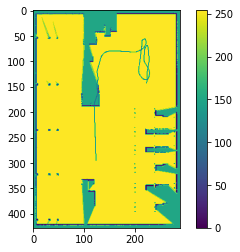

In [80]:
plt.figure()
plt.imshow(map_img)
plt.colorbar()
plt.grid(False)
plt.show()